In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 25 
LEARNING_RATE = 0.0001

print("Đã import thư viện thành công!")

Đã import thư viện thành công!


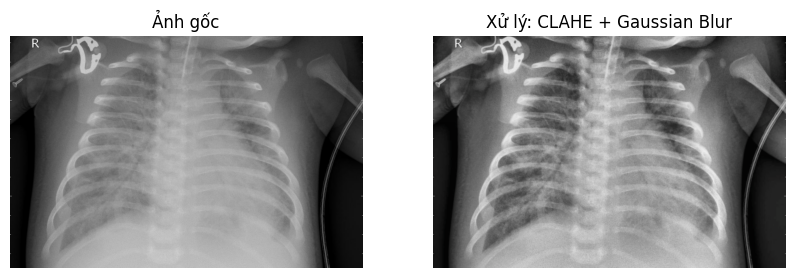

In [2]:
def custom_preprocessing(img):
    """
    1. Chuyển sang không gian màu LAB
    2. Áp dụng CLAHE lên kênh L 
    3. Hợp nhất lại và chuyển về RGB
    4. Gaussian Blur
    """
    try:
        img = img.astype('uint8')
        
        # 1. Chuyển đổi sang LAB
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        
        # 2. Áp dụng CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        
        # 3. Gộp lại
        limg = cv2.merge((cl, a, b))
        final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
        
        # 4. Gaussian Blur
        final_img = cv2.GaussianBlur(final_img, (3, 3), 0)
        
        return final_img.astype('float32')
    except Exception as e:
        return img 

# Demo
def visualize_preprocessing(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    processed = custom_preprocessing(img)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Ảnh gốc")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed.astype('uint8'))
    plt.title("Xử lý: CLAHE + Gaussian Blur")
    plt.axis('off')
    plt.show()

sample_path = 'chest_xray/train/PNEUMONIA/' + os.listdir('chest_xray/train/PNEUMONIA/')[0]
visualize_preprocessing(sample_path)

In [3]:
# 1. Tạo DataFrame
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
categories = ['NORMAL', 'PNEUMONIA']

def create_dataframe(data_dir):
    filepaths = []
    labels = []
    if os.path.exists(data_dir):
        for cat in categories:
            folder = os.path.join(data_dir, cat)
            for fname in os.listdir(folder):
                filepaths.append(os.path.join(folder, fname))
                labels.append(cat)
    return pd.DataFrame({'Filename': filepaths, 'Label': labels})

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

print(f"Số lượng ảnh Train: {len(train_df)}")
print(f"Số lượng ảnh Test: {len(test_df)}")

# 2. Khởi tạo Data Generator với Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_preprocessing, 
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_preprocessing
)

# 3. Load dữ liệu vào bộ nhớ
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='Filename', y_col='Label',
    subset='training', batch_size=BATCH_SIZE, seed=42,
    shuffle=True, class_mode='binary', target_size=IMG_SIZE
)

val_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='Filename', y_col='Label',
    subset='validation', batch_size=BATCH_SIZE, seed=42,
    shuffle=True, class_mode='binary', target_size=IMG_SIZE
)

test_generator = test_datagen.flow_from_dataframe(
    test_df, x_col='Filename', y_col='Label',
    batch_size=BATCH_SIZE, seed=42,
    shuffle=False,
    class_mode='binary', target_size=IMG_SIZE
)

# Tính trọng số lớp 
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(train_generator.classes), y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Trọng số lớp (Class Weights): {class_weight_dict}")

Số lượng ảnh Train: 5216
Số lượng ảnh Test: 624
Found 4173 validated image filenames belonging to 2 classes.
Found 1043 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Trọng số lớp (Class Weights): {0: np.float64(7.001677852348993), 1: np.float64(0.5384516129032259)}


In [4]:
def build_cnn_model():
    model = Sequential([
        Input(shape=(150, 150, 3)),
        
        # Block 1
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(), # Giúp ổn định quá trình train
        MaxPooling2D(2,2),
        
        # Block 2
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        # Block 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        # Block 4
        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        # Phần phân loại
        Flatten(),
        Dropout(0.5), 
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid') 
    ])
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,699,265 (21.74 MB)

 Trainable params: 5,698,305 (21.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [5]:
print("Bắt đầu huấn luyện mô hình...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weight_dict, 
    verbose=1
)
print("Huấn luyện hoàn tất!")

Bắt đầu huấn luyện mô hình...
Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.8169 - loss: 0.7456 - val_accuracy: 0.0000e+00 - val_loss: 9.7278
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.8627 - loss: 0.3541 - val_accuracy: 0.0000e+00 - val_loss: 19.5991
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8768 - loss: 0.2912 - val_accuracy: 0.0000e+00 - val_loss: 8.6345
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 125s 952ms/step - accuracy: 0.8795 - loss: 0.3095 - val_accuracy: 0.3375 - val_loss: 1.3180
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 130s 995ms/step - accuracy: 0.8924 - loss: 0.2541 - val_accuracy: 0.6376 - val_loss: 0.7554
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 988ms/step - accuracy: 0.8948 - loss: 0.2432 - val_accuracy: 0.9291 - val_loss: 0.2059
Epoch 7/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 124s 946ms/step - accuracy: 0.8936 - loss: 0.2534 - val_accuracy: 0.9703 - val_loss: 0.1150
Epoch 8/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 12

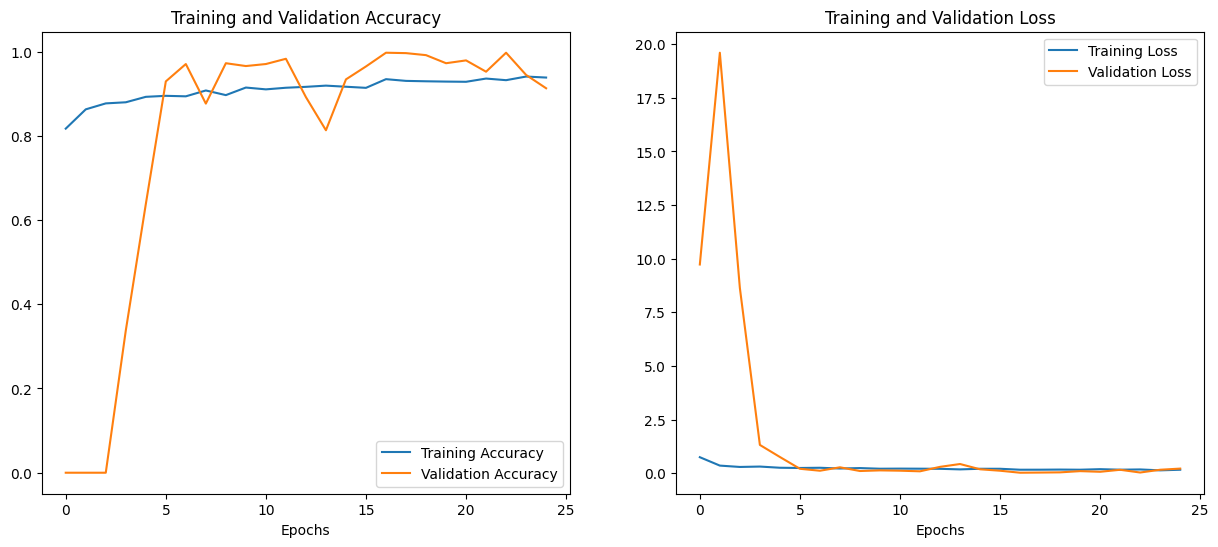

Đang đánh giá trên tập Test...
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step


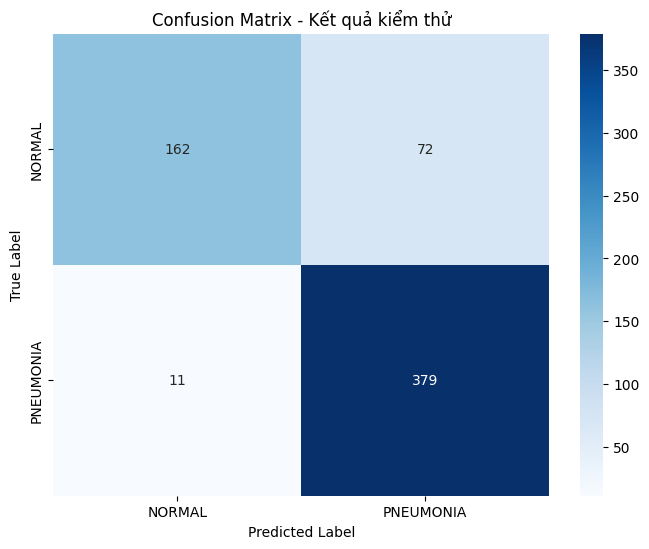


--- BÁO CÁO PHÂN LOẠI ---
              precision    recall  f1-score   support

      NORMAL       0.94      0.69      0.80       234
   PNEUMONIA       0.84      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.show()

print("Đang đánh giá trên tập Test...")
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Kết quả kiểm thử')
plt.show()

print("\n--- BÁO CÁO PHÂN LOẠI ---")
print(classification_report(y_true, y_pred, target_names=class_names))

In [7]:
model.save('pneumonia_custom_cnn.keras')
print("Đã lưu mô hình thành công!")

Đã lưu mô hình thành công!
